## Preparation

Important!

In [1]:
#This code works only on pandas 1.X
!pip install pandas==1.5.3


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Module imports

In [2]:
import dropbox
import config
import requests
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import scipy
import sklearn
from sklearn import metrics
import pandas as pd
from scipy.stats import pearsonr,f
import warnings
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

Variables

In [ ]:
#categories on a high level
healthcare_categories = ['Pharmaceuticals', 'Health Care Equipment & Supplies', 'Biotechnology', 'Life Sciences Tools & Services', 'Health Care Providers & Services', 'Health Care Technology', 'Tobacco', 'Marine']
consumer_categories = ['Food Products', 'Specialty Retail', 'Household Durables', 'Food & Staples Retailing', 'Beverages', 'Household Products', 'Textiles, Apparel & Luxury Goods', 'Multiline Retail', 'Personal Products', 'Hotels, Restaurants & Leisure', 'Building Products', 'Airlines', 'Containers & Packaging', 'Automobiles', 'Auto Components', 'Entertainment', 'Leisure Products', 'Transportation Infrastructure', 'Diversified Consumer Services', 'Distributors']
tech_categories = ['Semiconductors & Semiconductor Equipment', 'IT Services', 'Software', 'Technology Hardware, Storage & Peripherals', 'Interactive Media & Services', 'Software', 'Technology Hardware, Storage & Peripherals', 'Health Care Technology', 'Machinery', 'Media', 'Aerospace & Defense', 'Communications Equipment', 'Electrical Equipment', 'Electronic Equipment, Instruments & Components', 'Wireless Telecommunication Services', 'Internet & Direct Marketing Retail']
finance_categories = ['Banks', 'Capital Markets', 'Insurance', 'Consumer Finance', 'Thrifts & Mortgage Finance', 'Equity Real Estate Investment Trusts (REITs)', 'Commercial Services & Supplies', 'Diversified Telecommunication Services', 'Professional Services', 'Real Estate Management & Development', 'Industrial Conglomerates', 'Paper & Forest Products', 'Diversified Financial Services', 'Construction & Engineering', 'Trading Companies & Distributors']
energy_categories = ['Oil, Gas & Consumable Fuels', 'Electric Utilities', 'Energy Equipment & Services', 'Independent Power and Renewable Electricity Producers', 'Gas Utilities', 'Metals & Mining', 'Multi-Utilities', 'Construction Materials', 'Road & Rail', 'Air Freight & Logistics', 'Water Utilities', 'Chemicals']

#parameters for models
FLOAT_LEARNING_RATE = 0.0000025
LAMBDA = 0.2
P_LAGS = 2

Visual setting

In [4]:
#set visible columns to max
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Methods

## Data 

#### Lets gather the data

First we import the data form our local folder or from dropbox

In [5]:
def download_excel_file(url, output_file):
    """
    Download an Excel file from a URL and save it locally.
    """
    # Modify the Dropbox URL to force download
    download_url = url.replace("?dl=0", "?dl=1")

    # Send an HTTP GET request to download the file
    response = requests.get(download_url)

    # Check if the request was successful (HTTP status code 200)
    if response.status_code == 200:
        # Create the output folder if it does not exist
        output_folder = os.path.dirname(output_file)
        if output_folder and not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Save the file in the output folder
        with open(output_file, "wb") as file:
            file.write(response.content)
    else:
        print("Error: Unable to download the file")


Now lets define the categories on the high level

For the data generation via yahoo please see the Deprecated folder
!Warning! it is highly unstructured code, since it was not used for any insights

Lets import some Data from refinitive. Since the data validity is not given with the beta version of the refinitive Python Api. Anyways, hence it may help some people, here is the function (to get data without the API-KEY). It is not called, but the data can be downloaded with the function call. It is important to have a open session of refinitive workspace running on the PC. More methods can be found in the Deprecated folder. 

In [6]:
def show_how_to_get_data_from_refinitive():
    """
    example function to show how to get data from refinitive. Just to help if needed, absolutely no guarantee that it still works
    """
    
    #wee need this module to get the data from refinitive (still, eikon is also possible, but does not work well)
    import refinitiv.data as rd
    #if you want to use eikon, import it like this
    #import refinitiv.data.eikon as ek
    
    import Deprecated.refinitive_fields
    #in the ressource_use_fields.py file, we lists with all the fields we can use
    #each key represents the categorie
    import Deprecated.refinitive_fields as refinitive_fields
    #let us import all the reccources use fields of the ESG
    list_ressource_use_fields = refinitive_fields.ressource_use_fields
    
    #first we have to open a session
    rd.open_session()
    #now we just makeour query
    #universe is the ticker of the company(ies), fields are the fields we want to get, start and end are the start and end date of the data, interval is the interval of the data
    #to use eikon
    df = rd.get_history(
        universe = ['MBGn.DE'],
        fields = list_ressource_use_fields,
        start = "2000-01-01",
        end = "2022-12-31",
        interval='yearly',
    )
    return df

#### Let´s clean the Data

Make the data readable

In [7]:
def refinite_to_python(file_path):
    """
    Make a file from the refinitive screener readable for python and useable for the analysis.
    input: file_path
    output: cleaned dataframe
    """
    
    # Read data from excel file
    df_all_comp_all = pd.read_excel(file_path, header=[0, 1])

    # Combine multilevel columns into a single level
    cols = df_all_comp_all.columns
    df_all_comp_all.columns = ['_'.join(col).strip() for col in cols]

    # Rename columns for better understanding
    if "Company Name_Unnamed: 1_level_1" in df_all_comp_all.columns:
        df_all_comp_all.rename(columns={"Company Name_Unnamed: 1_level_1": "Company Name"}, inplace=True)
    if "Identifier (RIC)_Unnamed: 0_level_1" in df_all_comp_all.columns:
        df_all_comp_all.rename(columns={"Identifier (RIC)_Unnamed: 0_level_1": "RIC"}, inplace=True)
    if "Country of Headquarters_Unnamed: 2_level_1" in df_all_comp_all.columns:
        df_all_comp_all.rename(columns={"Country of Headquarters_Unnamed: 2_level_1": "Country of Headquarters"}, inplace=True)
    if "NAICS Subsector Name_Unnamed: 5_level_1" in df_all_comp_all.columns:
        df_all_comp_all.rename(columns={"NAICS Subsector Name_Unnamed: 5_level_1": "NAICS Subsector Name"}, inplace=True)
    if "GICS Industry Name_GICS Industry Name" in df_all_comp_all.columns:
        df_all_comp_all.rename(columns={"GICS Industry Name_GICS Industry Name": "GICS Industry Name"}, inplace=True)

    # Remove unwanted characters from column names
    df_all_comp_all.columns = df_all_comp_all.columns.str.replace('\nIn the last 10 FY_FY', ' ')
    df_all_comp_all.columns = df_all_comp_all.columns.str.replace("\nIn the last 15 Y_Y"," ")
    df_all_comp_all.columns = df_all_comp_all.columns.str.replace('-', '')
    

    # Create a copy of the DataFrame
    df_all_comp = df_all_comp_all.copy()
    #return df_all_comp
    #check if the YTD Total Return 11, 12, 13, 14 are in the dataframe
    if "YTD Total Return 11" in df_all_comp.columns:  
        df_all_comp.drop(columns=["YTD Total Return 11"], inplace=True)
    if "YTD Total Return 12" in df_all_comp.columns:
        df_all_comp.drop(columns=["YTD Total Return 12"], inplace=True)  
    if "YTD Total Return 13" in df_all_comp.columns:
        df_all_comp.drop(columns=["YTD Total Return 13"], inplace=True)    
    if "YTD Total Return 14" in df_all_comp.columns:
        df_all_comp.drop(columns=["YTD Total Return 14"], inplace=True)


    # Drop rows with all NaN values and fill remaining NaNs with 0
    df_all_comp.dropna(inplace=True, how="all")
    df_all_comp.fillna(0, inplace=True)


    # Extract unique column prefixes
    list_columns = [col for col in df_all_comp.columns if col[-1].isdigit()]
    list_columns = [col[:-1] for col in list_columns]
    list_columns = [col[:-1] if col[-1].isdigit() else col for col in list_columns]
    list_columns = list(set(list_columns))
    list_columns = [col.replace("\n", "") for col in list_columns]

    # Initialize an empty list to store DataFrames
    dfs = []

    # Iterate over unique column prefixes
    for colum in tqdm(list_columns):
        esg_cols = [col for col in df_all_comp.columns if col.startswith(colum)]
        df = df_all_comp[["Company Name"] + esg_cols].copy()

        # Melt the DataFrame to transform it into the desired format
        melted_df = df.melt(
            id_vars=["Company Name"],
            var_name="Period",
            value_name=colum
        )
        melted_df["Period"] = melted_df["Period"].apply(lambda x: 1 if x[-1].isdigit() == False else 10 if x[-2:-1] == "10" else int(x[-1]))

        dfs.append(melted_df)

    # Concatenate the melted DataFrames
    melted_df_all = pd.concat(dfs, axis=1)

    # Remove duplicate columns
    melted_df_all = melted_df_all.loc[:, ~melted_df_all.columns.duplicated()]

    # Sort the DataFrame by Company Name and Period
    melted_df_all = melted_df_all.sort_values(by=["Company Name", "Period"])

    # Create a copy of the final DataFrame
    df_data_ = melted_df_all.copy()
    
    #replace all 0 with nan, except for the period column
    #it is important to diffirentiate between 0 and nan, for example for the correlation
    df_data_ = df_data_.replace(0, np.nan)
    df_data_ = df_data_.replace("0", np.nan)
    df_data_["Period"] = df_data_["Period"].fillna(0)

    #add RIC, Country of Headquarters and NAICS Subsector Name to the dataframe
    #fill nan of RIC, Country of Headquarters and NAICS Subsector Name with the last value that is not nan
    if "RIC" in df_all_comp_all.columns:
        df_data_["RIC"] = df_all_comp_all["RIC"]
        df_data_["RIC"] = df_data_.groupby("Company Name")["RIC"].ffill()   
    if "Country of Headquarters" in df_all_comp_all.columns:
        df_data_["Country of Headquarters"] = df_all_comp_all["Country of Headquarters"]
        df_data_["Country of Headquarters"] = df_data_.groupby("Company Name")["Country of Headquarters"].ffill()            
    if "NAICS Subsector Name" in df_all_comp_all.columns:
        df_data_["NAICS Subsector Name"] = df_all_comp_all["NAICS Subsector Name"]
        df_data_["NAICS Subsector Name"] = df_data_.groupby("Company Name")["NAICS Subsector Name"].ffill()   
    if "GICS Industry Name" in df_all_comp_all.columns:
        df_data_["GICS Industry Name"] = df_all_comp_all["GICS Industry Name"]
        df_data_["GICS Industry Name"] = df_data_.groupby("Company Name")["GICS Industry Name"].ffill()

    #remove all the whitespaces in the end of a column name
    df_data_.columns = df_data_.columns.str.rstrip()
        
    if "ESG Score " in df_data_.columns:
        #make sure only one ESG Score column is in the dataframe
        df_data_["ESG Score"] = df_data_["ESG Score "]

    
    return df_data_
    

In [8]:
def refinite_to_python_EBITDA(filepath):
    """ 
    This function reads the EBITDA data from Refinitiv and returns a DataFrame with the data.
    Works as a workaround for the Bugs occuring in the normal function
    """

    df_ebitda = pd.read_excel(filepath, header=[0, 1])
    # Combine multilevel columns into a single level
    cols = df_ebitda.columns
    df_ebitda.columns = ['_'.join(col).strip() for col in cols]
    # Remove unwanted characters from column names
    df_ebitda.columns = df_ebitda.columns.str.replace('\nIn the last 10 FY_FY', ' ')
    df_ebitda.columns = df_ebitda.columns.str.replace("\nIn the last 15 Y_Y"," ")
    df_ebitda.columns = df_ebitda.columns.str.replace('-', '')

    # Drop rows with all NaN values and fill remaining NaNs with 0
    df_ebitda.dropna(inplace=True, how="all")
    df_ebitda.fillna(0, inplace=True)

    # Rename columns for better understanding
    if "Company Name_Unnamed: 1_level_1" in df_ebitda.columns:
        df_ebitda.rename(columns={"Company Name_Unnamed: 1_level_1": "Company Name"}, inplace=True)
    if "Identifier (RIC)_Unnamed: 0_level_1" in df_ebitda.columns:
        df_ebitda.rename(columns={"Identifier (RIC)_Unnamed: 0_level_1": "RIC"}, inplace=True)
    if "Country of Headquarters_Unnamed: 2_level_1" in df_ebitda.columns:
        df_ebitda.rename(columns={"Country of Headquarters_Unnamed: 2_level_1": "Country of Headquarters"}, inplace=True)
    if "NAICS Subsector Name_Unnamed: 5_level_1" in df_ebitda.columns:
        df_ebitda.rename(columns={"NAICS Subsector Name_Unnamed: 5_level_1": "NAICS Subsector Name"}, inplace=True)
    if "GICS Industry Name_GICS Industry Name" in df_ebitda.columns:
        df_ebitda.rename(columns={"GICS Industry Name_GICS Industry Name": "GICS Industry Name"}, inplace=True)


    # Extract unique column prefixes
    list_columns = [col for col in df_ebitda.columns if col[-1].isdigit()]
    list_columns = [col[:-1] for col in list_columns]
    list_columns = [col[:-1] if col[-1].isdigit() else col for col in list_columns]
    list_columns = list(set(list_columns))
    list_columns = [col.replace("\n", "") for col in list_columns]

    # Initialize an empty list to store DataFrames
    dfs = []

    # Iterate over unique column prefixes
    for colum in tqdm(list_columns):
        esg_cols = [col for col in df_ebitda.columns if col.startswith(colum)]
        df = df_ebitda[["Company Name"] + esg_cols].copy()

        # Melt the DataFrame to transform it into the desired format
        melted_df = df.melt(
            id_vars=["Company Name"],
            var_name="Period",
            value_name=colum
        )
        melted_df["Period"] = melted_df["Period"].apply(lambda x: 1 if x[-1].isdigit() == False else 10 if x[-2:-1] == "10" else int(x[-1]))

        dfs.append(melted_df)

    # Concatenate the melted DataFrames
    melted_df_all = pd.concat(dfs, axis=1)

    # Remove duplicate columns
    #melted_df_all = melted_df_all.loc[:, ~melted_df_all.columns.duplicated()]

    melted_df_all.fillna(0, inplace=True)
    df_new = pd.DataFrame()
    for column_ in melted_df_all.columns:
        #check if column is duplicate
        if column_ == "Company Name":
                #rename the column, cal
                X = pd.DataFrame(melted_df_all[column_])
                X.columns = [str(i) for i in range(X.shape[1])]
                #calculate the numbers of 0 in every column
                if 0 in X["0"].values:
                    col_1 = X["0"].value_counts().loc[0]
                else:  
                    col_1 = 0
                if 0 in X["1"].values:
                    col_2 = X["1"].value_counts().loc[0]
                else:
                    col_2 = 0
                if  col_1 < col_2:
                    df_new[column_] = X["0"]
                else:
                    df_new[column_] = X["1"]
        else:
                try:
                    if melted_df_all[column_].shape[1]>1:
                        #rename the column, cal
                        X = pd.DataFrame(melted_df_all[column_])
                        X.columns = [str(i) for i in range(X.shape[1])]
                        #calculate the numbers of 0 in every column
                        col_1 = X["0"].sum()
                        col_2 = X["1"].sum()
                        if  col_1 > col_2:
                            df_new[column_] = X["0"]
                        else:
                            df_new[column_] = X["1"]
                        
                except KeyboardInterrupt:
                    raise
                except Exception as e:
                    df_new[column_] = melted_df_all[column_]
                    pass

    melted_df_all = df_new.copy()
    # Sort the DataFrame by Company Name and Period
    melted_df_all = melted_df_all.sort_values(by=["Company Name", "Period"])

    # Create a copy of the final DataFrame
    df_data_ = melted_df_all.copy()

    #replace all 0 with nan, except for the period column
    #it is important to diffirentiate between 0 and nan, for example for the correlation
    df_data_ = df_data_.replace(0, np.nan)
    df_data_ = df_data_.replace("0", np.nan)
    df_data_["Period"] = df_data_["Period"].fillna(0)
    df_EBITDA_10Y_raw = df_data_.copy()
    return df_EBITDA_10Y_raw

Clean the data and add some clusters

In [9]:
def clean_data(df, esg_col = "ESG Score", return_col = "Return"):
    """
    Clean and preprocess a dataframe for clustering based on "ESG Score" and "Return" columns.

    Args:
        df (pd.DataFrame): The input dataframe to clean.
        esg_col (str): The column name for the ESG Score.
        return_col (str): The column name for the Return.

    Returns:
        pd.DataFrame: The cleaned and preprocessed dataframe.
    """

    # Make a copy of the input dataframe to avoid modifying it
    df_data = df.copy()
    
    #get only numeric columns
    numeric_columns = df_data.select_dtypes(['int64', 'float64']).columns

    # Drop rows with NaN values in "Return" or "ESG Score" columns
    df_data.dropna(subset=[return_col, esg_col], inplace=True)

    # Remove outliers in the "Return" column (more than 2 std away from the mean)
    return_mean = df_data[return_col].mean()
    return_std = df_data[return_col].std()
    df_data = df_data[(df_data[return_col] < return_mean + 2 * return_std) & (df_data[return_col] > return_mean - 2 * return_std)]
    #for clustering
    df_data_ = df_data.copy()
    df_data_.fillna(0, inplace=True)
    #make mean of company 
    df_data_ = df_data_.groupby("Company Name").mean()
    # Cluster the companies columns using KMeans
    model = KMeans(n_clusters=5)
    model.fit(df_data_[numeric_columns])
    labels = model.predict(df_data_[numeric_columns])
    df_data_["Cluster"] = labels
    #map back to the original dataframe based on the company name  
    df_data["Cluster"] = df_data["Company Name"].map(df_data_["Cluster"])
    # Return the cleaned dataframe
    
    return df_data

Add Transformation

In [10]:
def transform_columns(df,column):
    """
    takes a dataframe and a column name and transforms the column into:
    log
    log_2
    sqrt
    sqrt_2
    _2
    _3
    _4
    """
    
    df[column+"_log"] = np.log(df[column])
    df[column+"_log_2"] = np.log(df[column]**2)
    df[column+"_sqrt"] = np.sqrt(df[column])
    df[column+"_sqrt_2"] = np.sqrt(df[column]**2)
    df[column+"_2"] = df[column]**2
    df[column+"_3"] = df[column]**3
    df[column+"_4"] = df[column]**4
    
    return df

Scale the Data

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def scale_data(df: pd.DataFrame) -> pd.DataFrame:
    """Scale the numerical columns of the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The scaled DataFrame.
    """
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_columns) == 0:
        raise ValueError("No numerical columns in DataFrame")
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[numerical_columns])
    df_scaled = pd.DataFrame(df_scaled, columns=numerical_columns, index=df.index)
    return pd.concat([df.drop(columns=numerical_columns), df_scaled], axis=1)


### Lets dive deep in the data

## MATH Formulas

#### Let´s define our basic math functions 


Gradient Descent

In [12]:
def initialize_coefficients(n_features, n_targets):
    """
    Initializes the coefficients for VAR.
    
    Parameters:
        n_features (int): Number of input features.
        n_targets (int): Number of output targets.
        
    Returns:
        numpy.ndarray: An (n_features x n_targets) matrix of initialized coefficients.
    """
    return np.random.rand(n_features, n_targets)

def calculate_loss(X, Y, coefficients):
    """
    Calculates the mean squared error (MSE) for the current coefficients.
    
    Parameters:
        X (numpy.ndarray): An (n_samples x n_features) array of input data.
        Y (numpy.ndarray): An (n_samples x n_targets) array of output data.
        coefficients (numpy.ndarray): An (n_features x n_targets) matrix of current coefficients.
        
    Returns:
        float: The mean squared error (MSE) for the current coefficients.
    """
    predicted = np.dot(X, coefficients)
    errors = Y - predicted
    return np.sum(errors**2) / (2 * X.shape[0])

def calculate_lasso_loss(_X, _Y, coefficients, lambda_):
    """
    Calculates the LASSO loss for the current coefficients.

    Parameters:
        X (numpy.ndarray): An (n_samples x n_features) array of input data.
        Y (numpy.ndarray): An (n_samples x n_targets) array of output data.
        coefficients (numpy.ndarray): An (n_features x n_targets) matrix of current coefficients.
        lambda_ (float): The regularization parameter.

    Returns:
        float: The LASSO loss for the current coefficients.
    """
    errors = _Y - np.dot(_X, coefficients)
    mse = np.sum(errors**2) / (2 * _X.shape[0])
    l1_norm = np.sum(np.abs(coefficients))
    lasso_loss = mse + lambda_ * l1_norm
    return lasso_loss


def outer(a, b):
    """
    Computes the outer product of two 1-dimensional arrays.

    Parameters:
        a (array-like): 1-dimensional array.
        b (array-like): 1-dimensional array.

    Returns:
        2-dimensional array where the element at position (i, j) is the
        product of the i-th element of `a` and the j-th element of `b`.
    """
    outer_product = np.zeros((len(a), len(b)))  # initialize the result with zeros
    for i in range(len(a)):
        for j in range(len(b)):
            outer_product[i, j] = a[i] * b[j]  # compute the product of the i-th element of a and the j-th element of b
    return outer_product



def calculate_gradient(X, Y, coefficients):
    """
    Calculates the gradient of the loss function with respect to the coefficients.
    
    Parameters:
        X (numpy.ndarray): An (n_samples x n_features) array of input data.
        Y (numpy.ndarray): An (n_samples x n_targets) array of output data.
        coefficients (numpy.ndarray): An (n_features x n_targets) matrix of current coefficients.
        
    Returns:
        numpy.ndarray: An (n_features x n_targets) matrix of gradient values.
    """
    n_samples = X.shape[0]
    #without Lasso
    #grad = np.dot(X.T, np.dot(X, coefficients) - Y) / n_samples
    global LAMBDA
    grad = (1/n_samples) * np.dot(X.T, np.dot(X, coefficients) - Y) + LAMBDA * np.sign(coefficients)  
    return grad

def update_coefficients(coefficients, gradients, lr):
    """
    Updates the coefficients using the gradient and the learning rate.
    
    Parameters:
        coefficients (numpy.ndarray): An (n_features x n_targets) matrix of current coefficients.
        gradients (numpy.ndarray): An (n_features x n_targets) matrix of gradient values.
        lr (float): Learning rate for the optimization algorithm.
        
    Returns:
        numpy.ndarray: An (n_features x n_targets) matrix of updated coefficients.
    """
    return coefficients - lr * gradients

def gradient_descent_step(X__, Y__, coefficients__, lr):
    """
    Performs a single step of gradient descent for VAR.
    
    Parameters:
        X (numpy.ndarray): An (n_samples x n_features) array of input data.
        Y (numpy.ndarray): An (n_samples x n_targets) array of output data.
        coefficients (numpy.ndarray): An (n_features x n_targets) matrix of current coefficients.
        lr (float): Learning rate for the optimization algorithm.
        
    Returns:
        tuple: A tuple containing the updated coefficients and the loss for the current iteration.
    """
    global LAMBDA
    lambda_=1 + LAMBDA #variieren mit cosine similarity
    gradients = calculate_gradient(X__, Y__, coefficients__)
    updated_coefficients = update_coefficients(coefficients__, gradients, lr)
    loss = calculate_lasso_loss(X__, Y__, coefficients__, lambda_)
    return updated_coefficients, loss



F-Test

In [13]:
def calculate_f_statistic(sample1, sample2):
    """
    Calculates the F-statistic for two samples.

    Parameters:
        sample1 (numpy.ndarray): An array of values for the first sample.
        sample2 (numpy.ndarray): An array of values for the second sample.

    Returns:
        float: The F-statistic for the two samples.
    """
    var1 = np.var(sample1)
    var2 = np.var(sample2)
    return var1 / var2


def calculate_critical_value(sample1, sample2, alpha):
    """
    Calculates the critical value of the F-distribution for two samples.

    Parameters:
        sample1 (numpy.ndarray): An array of values for the first sample.
        sample2 (numpy.ndarray): An array of values for the second sample.
        alpha (float): The significance level.

    Returns:
        float: The critical value of the F-distribution for the two samples.
    """
    df1 = len(sample1) - 1
    df2 = len(sample2) - 1
    return f.ppf(q=1 - alpha, dfn=df1, dfd=df2)


def compare_f_statistic_to_critical_value(f_statistic, critical_value):
    """
    Compares the F-statistic to the critical value of the F-distribution.

    Parameters:
        f_statistic (float): The F-statistic for the two samples.
        critical_value (float): The critical value of the F-distribution for the two samples.
    """
    if f_statistic > critical_value:
        print("Reject the null hypothesis that the variances are equal")
        return False
    else:
        print("Accept the null hypothesis that the variances are equal")
        return True

Cosine similarity

In [14]:
def cosine_similarity(v1, v2):
    """
    calculates the cosine similarity between two vectors
    input: v1, v2: numpy arrays
    output: cosine similarity (float) 
    """
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def cosine_similarity_matrix(A,B):
    """
    calculates the cosine similarity similarity between the rows of A and B
    """
    return np.array([cosine_similarity(A[i,:],B[i,:]) for i in range(A.shape[0])])

#calculate the cosine similarity for every company to every other company
#select only the numerical columns


Lag Matrix

In [15]:
def lag_matrix(X,p):
    """
    lags matrix X by p
    """
    X_lagged = np.zeros((X.shape[0]-p,X.shape[1]*p))
    for i in range(p):
        X_lagged[:,i*X.shape[1]:(i+1)*X.shape[1]] = X[p-i-1:-i-1,:]
    return X_lagged

calculate optimal number cluster

In [16]:
def find_optimal_clusters(df_scaled: pd.DataFrame) -> int:
    """Find the optimal number of clusters using silhouette, calinski_harabasz,
    and davies_bouldin scores.

    Args:
        df_scaled (pd.DataFrame): The scaled DataFrame.

    Returns:
        int: The optimal number of clusters.
    """
    scores = {}
    #fill missing values with 0
    df_scaled = df_scaled.fillna(0)
    #make sure only numeric columns are used
    list_numeric_columns = df_scaled.select_dtypes(include=['float64', 'int64']).columns
    df_scaled_num = df_scaled[list_numeric_columns]
    
    for n_clusters in tqdm(range(3, 100, 3)):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_scaled_num)
        scores[n_clusters] = sum((
            silhouette_score(df_scaled_num, kmeans.labels_),
            calinski_harabasz_score(df_scaled_num, kmeans.labels_),
            davies_bouldin_score(df_scaled_num, kmeans.labels_)
        ))
    return max(scores, key=scores.get)

Cluster the Companies (KMeans)

In [17]:
def cluster_companies(df_data: pd.DataFrame, min_size: int = 15,
                      cluster_size: int = 0
                      ) -> pd.DataFrame:
    """Cluster the companies based on all the data into the optimal number of
    clusters, but every cluster has at least `min_size` companies.

    Args:
        df_data (pd.DataFrame): The input DataFrame.
        min_size (int, optional): The minimum number of companies per cluster.
            Defaults to 15.
        cluster_size (int, optional): The number of clusters to use. If 0, the
            

    Returns:
        pd.DataFrame: The input DataFrame with an additional column 'cluster'
        indicating the cluster number for each company.
    """
    # Scale the data
    df_scaled = scale_data(df_data)

    # Find the optimal number of clusters if not provided
    if cluster_size == 0:
        optimal_clusters = find_optimal_clusters(df_scaled)
    else:
        optimal_clusters = cluster_size

    # Perform the clustering
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=0).fit(df_scaled)
    df_data['cluster'] = kmeans.labels_

    # Filter out clusters with less than `min_size` companies
    df_data['cluster_size'] = df_data.groupby('cluster').transform('count')['id']
    df_data = df_data[df_data['cluster_size'] >= min_size]
    return df_data


Perform correlation analysis

In [18]:
def group_corr(df_data, column_corr_a, column_corr_b, column_grop="Company Name"):
    """
    This function calculates the correlation between two columns, grouped by a third column,
    and then visualizes the distribution of the correlations using a distribution plot.
    
    Args:
        df_data (pd.DataFrame): The input dataframe containing the data.
        column_corr_a (str): The first column to calculate the correlation.
        column_corr_b (str): The second column to calculate the correlation.
        column_grop (str, optional): The column to group by. Defaults to "Company Name".

    Returns:
        df_corr (pd.DataFrame): A dataframe containing the grouped correlation values.
    """
    
    df_corr = df_data.groupby(column_grop).apply(lambda x: x[[column_corr_a, column_corr_b]].corr().iloc[0, 1])
    df_corr = df_corr.reset_index()
    df_corr.columns = [column_grop, "corr"]

    # Plot the distribution of correlations
    sns.distplot(df_corr["corr"])
    plt.title(f"Distribution of correlations between {column_corr_a} and {column_corr_b}")

    # Add mean and median lines
    plt.axvline(df_corr["corr"].mean(), color="red", label="mean")
    plt.axvline(df_corr["corr"].median(), color="green", label="median")
    plt.legend()
    plt.show()

    return df_corr


In [19]:
def lagged_corr(df_data, column_corr_a, column_corr_b, column_grop="Company Name", p=1, time_column="Period"):
    """
    Calculates lagged correlation between two columns, grouped by a third column
    e.g. if group is company name, it calculates the correlation for column_corr_a to the column_corr_b of last period of the company.
    For the oldest period of the company the correlation can't be determined, so it is set to nan.
    
    Args:
        df_data (pd.DataFrame): Input data frame with the data
        column_corr_a (str): First column for correlation calculation
        column_corr_b (str): Second column for correlation calculation
        column_grop (str, optional): Column to group data by. Defaults to "Company Name".
        p (int, optional): Number of periods to lag. Defaults to 1.
        time_column (str, optional): Column containing time periods. Defaults to "Period".
    
    Returns:
        pd.DataFrame: Data frame with calculated lagged correlations
    """

    # Create a copy of the input dataframe to avoid modifying the original dataframe
    df = df_data.copy()

    # Shift column_corr_b by p periods
    df['shifted_column_corr_b'] = df.groupby(column_grop)[column_corr_b].shift(p)

    # Calculate correlation for each group
    df_corr = df.groupby(column_grop).apply(lambda x: x[[column_corr_a, 'shifted_column_corr_b']].corr().iloc[0, 1])

    # Create a new dataframe with the correlation results
    df_result = pd.DataFrame(df_corr).reset_index()
    df_result.columns = [column_grop, 'lagged_correlation']

    return df_result


#### Let´s define our main models


VAR (Vektor Auto Regression)

In [20]:
def VAR_model(X, p):
    """
    This function takes a matrix X and a number of lags p and performs a VAR(p) model on the data.
    It returns the mean squared error and the R2 score, the matrix anf the coefficients.
    
    """
    n_samples, n_features = X.shape

    X_lagged = np.zeros((n_samples - p, p * n_features))
    for i in range(p):
        X_lagged[:, i*n_features:(i+1)*n_features] = X[p-i-1:-i-1, :]

    # Split the data into training and testing sets
    train_size = int(0.8 * n_samples)
    X_train = X_lagged[:train_size, :]
    Y_train = X[p:train_size+p, :]
    X_test = X_lagged[train_size-p:-p, :]
    Y_test = X[train_size+p:, :]
    # Compute the coefficients using the training set
    coeffs = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ Y_train

    # make predictions for the test set
    Y_pred = X_test @ coeffs

    # calculate the mean squared error
    mse = np.mean((Y_test - Y_pred)**2)
    #calculate the R2 score
    r2 = 1 - np.sum((Y_test - Y_pred)**2) / np.sum((Y_test - np.mean(Y_test))**2)

    
    #return the mean squared error and the R2 score, the matrix anf the coefficients
    return mse, r2, X_lagged, coeffs

Industry beta on VAR Model 

In [21]:
def industry_beta(X_industry, y, coeffs_industry):
    # Add a column of ones to the left of X_industry for the intercept

    # Create a new matrix W where W = X @ coeffs_industry_with_intercept
    W = X_industry @ coeffs_industry
    #add a column of ones to the left of W
    W = np.hstack((np.ones((W.shape[0], 1)), W))
    


    # Use the normal equation to find the optimal beta and intercept
    # (W.T @ W)^(-1) @ W.T @ y
    optimal_beta_intercept = np.linalg.inv(W.T @ W) @ W.T @ y

    return float(optimal_beta_intercept[1]), float(optimal_beta_intercept[0])

#### Granger Test

Granger test based on VAR (simple)

In [22]:
def check_granger_simple(df_data: pd.DataFrame, p: int, column_A: str, column_B: str) -> tuple:
    """
    Check for Granger causality between two variables, given a pandas DataFrame with columns 'Company Name', 'Period',
    'Return', and 'ESG Score'.

    Parameters:
    df_data (pd.DataFrame): A pandas DataFrame with columns 'Company Name', 'Period', 'Return', and 'ESG Score'.
    p (int): The number of lags to include in the VAR models.
    column_A (str): The name of the first column to test for Granger causality. Caused by column_B.
    column_B (str): The name of the second column to test for Granger causality. Causes column_A.

    Returns:
    A tuple containing the residuals, y, and coefficients for each of the three VAR models, as well as the R-squared
    values, F-statistics, and critical values for the Granger causality tests.
    """

    # Create a copy of the input dataframe to avoid modifying the original
    df_data_old = df_data.copy()

    # Initialize an empty dataframe with the same columns as the input dataframe
    df_data = pd.DataFrame(columns=df_data.columns)

    # Iterate through all unique company names in the input dataframe
    for company in df_data_old["Company Name"].unique():
        X_company = df_data_old[df_data_old["Company Name"] == company]

        # Only process companies with more than 5 data points
        if X_company.shape[0] > 5:
            # Add 'p' rows of zeros to the beginning of each company's data
            X_c = pd.DataFrame(columns=df_data.columns)
            X_c = X_c.append([X_company.iloc[0]] * p, ignore_index=True)
            X_c = X_c * 0
            X_c["Period"] = list(range(-p, 0))
            X_c = X_c.append(X_company, ignore_index=True)
            df_data = df_data.append(X_c, ignore_index=True)

    # Initialize the VAR models using different predictors
    # Model 1: column_A
    # Model 2: column_A, random noise
    # Model 3: column_A, column_B
    X1 = df_data[[column_A]].copy()
    X2 = df_data[[column_A]].copy()
    X2["random"] = np.random.rand(len(X2))
    X3 = df_data[[column_A, column_B]].copy()

    # Convert dataframes to numpy arrays
    X1, X2, X3 = X1.values, X2.values, X3.values

    # Fit the VAR models with 'p' lags
    mse1, r21, X_lagged1, coeffs_1 = VAR_model(X1, p)
    mse2, r22, X_lagged2, coeffs_2 = VAR_model(X2, p)
    mse3, r23, X_lagged3, coeffs_3 = VAR_model(X3, p)

    # Calculate the residuals for each model
    y = df_data[column_A].values[p:]
    residuals_1 = y - (X_lagged1 @ coeffs_1)[:, 0]
    residuals_2 = y - (X_lagged2 @ coeffs_2)[:, 0]
    residuals_3 = y - (X_lagged3 @ coeffs_3)[:, 0]

    # Define a function to calculate R-squared from residuals
    def r2_from_residuals(y,residuals):
        """
        Calculate the R-squared value from the residuals of a model.

        Parameters:
        y (numpy.ndarray): The dependent variable.
        residuals (numpy.ndarray): The residuals of the model.

        Returns:
        The R-squared value.
        """
        SST = sum((y - np.mean(y)) ** 2)
        SSR = sum(residuals ** 2)
        R2 = 1 - (SSR / SST)
        return R2

    # Print R-squared values for each model
    print(f"R-squared (Model 1): {r2_from_residuals(y, residuals_1)}")
    print(f"R-squared (Model 2): {r2_from_residuals(y, residuals_2)}")
    print(f"R-squared (Model 3): {r2_from_residuals(y, residuals_3)}")

    # Perform F-tests to compare residuals between models
    F12 = calculate_f_statistic(residuals_1, residuals_2)
    F13 = calculate_f_statistic(residuals_1, residuals_3)
    print(f"F-statistic (Model 1 vs Model 2): {F12}")
    print(f"F-statistic (Model 1 vs Model 3): {F13}")

    critical_value12 = calculate_critical_value(residuals_1, residuals_2, alpha=0.05)
    critical_value13 = calculate_critical_value(residuals_1, residuals_3, alpha=0.05)
    print(f"Critical value (Model 1 vs Model 2): {critical_value12}")
    print(f"Critical value (Model 1 vs Model 3): {critical_value13}")

    # Compare F-statistics to critical values
    print("Test whether random noise improves Model 1:")
    compare_f_statistic_to_critical_value(F12, critical_value12)
    print("Test whether column_B improves Model 1:")
    compare_f_statistic_to_critical_value(F13, critical_value13)

    # Return the residuals, y, and coefficients for each model
    return (residuals_1, residuals_2, residuals_3, y,
            coeffs_1, coeffs_2, coeffs_3)



Granger with industry beta

In [23]:
def check_granger_industry_beta(df_data: pd.DataFrame, p: int, column_A: str, column_B: str, column_industry: str, industry_name: str) -> tuple:
    """
    Check for Granger causality between two variables, given a pandas DataFrame with columns 'Company Name', 'Period',
    'Return', 'ESG Score', and the specified 'column_industry'.

    Parameters:
    df_data (pd.DataFrame): A pandas DataFrame with columns 'Company Name', 'Period', 'Return', 'ESG Score', and the specified 'column_industry'.
    p (int): The number of lags to include in the VAR models.
    column_A (str): The name of the first column to test for Granger causality.
    column_B (str): The name of the second column to test for Granger causality.
    column_industry (str): The name of the column containing industry information.
    industry_name (str): The name of the industry to filter by when performing the Granger causality test.

    Returns:
    A tuple containing the residuals for each of the three VAR models applied to the specified industry, the dependent variable (y),
    and the coefficients for each of the three VAR models.
    """

    # Create a copy of the input dataframe to avoid modifying the original
    df_data_old = df_data.copy()

    # Initialize an empty dataframe with the same columns as the input dataframe
    df_data = pd.DataFrame(columns=df_data.columns)

    # Iterate through all unique company names in the input dataframe
    for company in df_data_old["Company Name"].unique():
        X_company = df_data_old[df_data_old["Company Name"] == company]

        # Only process companies with more than 5 data points
        if X_company.shape[0] > 5:
            # Add 'p' rows of zeros to the beginning of each company's data
            X_c = pd.DataFrame(columns=df_data.columns)
            X_c = X_c.append([X_company.iloc[0]] * p, ignore_index=True)
            X_c = X_c * 0
            X_c["Period"] = list(range(-p, 0))
            X_c = X_c.append(X_company, ignore_index=True)
            df_data = df_data.append(X_c, ignore_index=True)

    # Initialize the VAR models using different predictors
    # Model 1: column_A
    # Model 2: column_A, random noise
    # Model 3: column_A, column_B
    X1 = df_data[[column_A]].copy()
    X2 = df_data[[column_A]].copy()
    X2["random"] = np.random.rand(len(X2))
    X3 = df_data[[column_A, column_B]].copy()

    # Convert dataframes to numpy arrays
    X1, X2, X3 = X1.values, X2.values, X3.values

    # Fit the VAR models with 'p' lags
    mse1, r21, X_lagged1, coeffs_1 = VAR_model(X1, p)
    mse2, r22, X_lagged2, coeffs_2 = VAR_model(X2, p)
    mse3, r23, X_lagged3, coeffs_3 = VAR_model(X3, p)
    

    #select only the industry rows from the data
    df_data_industry = df_data[df_data[column_industry] == industry_name]
    X1_industry = df_data_industry[[column_A]].copy()
    X2_industry = df_data_industry[[column_A]].copy()
    X2_industry["random"] = np.random.rand(len(X2_industry))
    X3_industry = df_data_industry[[column_A, column_B]].copy()
    
    # Convert dataframes to numpy arrays
    X1_industry, X2_industry, X3_industry = X1_industry.values, X2_industry.values, X3_industry.values

    # Fit the VAR models with 'p' lags
    mse1_industry, r21_industry, X_lagged1_industry,_= VAR_model(X1_industry, p)
    mse2_industry, r22_industry, X_lagged2_industry, _ = VAR_model(X2_industry, p)
    mse3_industry, r23_industry, X_lagged3_industry, _ = VAR_model(X3_industry, p)
    
    # Calculate the residuals for each model
    y = df_data_industry[column_A].values[p:]
    
    #add the industry beta
    
    industry_beta_1,industry_intercept_1 = industry_beta(X_lagged1_industry, y, coeffs_1)
    industry_beta_2,industry_intercept_2 = industry_beta(X_lagged2_industry, y, coeffs_2)
    industry_beta_3,industry_intercept_3 = industry_beta(X_lagged3_industry, y, coeffs_3)
    coeffs_1_industry = coeffs_1*industry_beta_1 
    coeffs_2_industry = coeffs_2*industry_beta_2
    coeffs_3_industry = coeffs_3*industry_beta_3

    
    
    residuals_1 = y - ((X_lagged1_industry @ coeffs_1_industry)[:, 0] + industry_intercept_1)
    residuals_2 = y - ((X_lagged2_industry @ coeffs_2_industry)[:, 0] + industry_intercept_2)
    residuals_3 = y - ((X_lagged3_industry @ coeffs_3_industry)[:, 0] + industry_intercept_3)

    # Define a function to calculate R-squared from residuals
    def r2_from_residuals(y,residuals):
        """
        Calculate the R-squared value from the residuals of a model.

        Parameters:
        y (numpy.ndarray): The dependent variable.
        residuals (numpy.ndarray): The residuals of the model.

        Returns:
        The R-squared value.
        """
        SST = sum((y - np.mean(y)) ** 2)
        SSR = sum(residuals ** 2)
        R2 = 1 - (SSR / SST)
        return R2

    # Print R-squared values for each model
    print(f"R-squared (Model 1): {r2_from_residuals(y, residuals_1)}")
    print(f"R-squared (Model 2): {r2_from_residuals(y, residuals_2)}")
    print(f"R-squared (Model 3): {r2_from_residuals(y, residuals_3)}")

    # Perform F-tests to compare residuals between models
    F12 = calculate_f_statistic(residuals_1, residuals_2)
    F13 = calculate_f_statistic(residuals_1, residuals_3)
    print(f"F-statistic (Model 1 vs Model 2): {F12}")
    print(f"F-statistic (Model 1 vs Model 3): {F13}")

    critical_value12 = calculate_critical_value(residuals_1, residuals_2, alpha=0.05)
    critical_value13 = calculate_critical_value(residuals_1, residuals_3, alpha=0.05)
    print(f"Critical value (Model 1 vs Model 2): {critical_value12}")
    print(f"Critical value (Model 1 vs Model 3): {critical_value13}")

    # Compare F-statistics to critical values
    compare_f_statistic_to_critical_value(F12, critical_value12)
    compare_f_statistic_to_critical_value(F13, critical_value13)

    # Return the residuals, y, and coefficients for each model
    return (residuals_1, residuals_2, residuals_3, y,
            coeffs_1_industry, coeffs_2_industry, coeffs_3_industry,
            industry_intercept_1, industry_intercept_2, industry_intercept_3)

Granger test based on Multiple Linear Regression (Vanilla /Lasso /Ridge)

In [24]:
def granger_mlr(data, target, predictors, p, companys, alpha_lasso=0.05):
    """
    This function performs Granger Causality tests using multivariate linear regression (MLR) models.
    It fits three models:
    1. Lasso Regression with the target and the lagged target as predictors
    2. Lasso Regression with the target, the lagged target, and the lagged predictors as predictors
    
    Args:
        data (DataFrame): The dataset containing the features and target.
        target (str): The target variable.
        predictors (list): The list of predictor variables.
        p (int): The number of lags to include in the models.
        companys (list): The list of companies to use for training, the rest will be used for testing.
        alpha_lasso (float): The Lasso regularization parameter. Default is 0.05.
        
    Returns:
        r2_residuals_1 (float): R-squared of the residuals of the first model.
        r2_residuals_2 (float): R-squared of the residuals of the second model.
        test_true (bool): The result of the F-test comparing the residuals of the two models.
        data_shape (tuple): The shape of the processed data.
    """
    # Preprocess data
    data = data.copy()
    data.dropna(inplace=True)
    data = data[np.isfinite(data[target])]
    data = data[np.isfinite(data[predictors])]

    # Split data into training and testing sets
    list_X_col = [target] + predictors + ["Company Name"]
    X_train = data[~data["Company Name"].isin(companys)][list_X_col].copy()
    X_test = data[data["Company Name"].isin(companys)][list_X_col].copy()
    Y_train = data[~data["Company Name"].isin(companys)][target].copy()
    Y_test = data[data["Company Name"].isin(companys)][target].copy()

    # Add lagged predictors and target variables
    for i in range(1, p + 1):
        lag = -i
        for pred in predictors:
            col_name = f"{pred}_shifted_{lag}"
            X_train[col_name] = X_train.groupby("Company Name")[pred].shift(lag)
            X_test[col_name] = X_test.groupby("Company Name")[pred].shift(lag)
        target_col_name = f"{target}_shifted{lag}"
        X_train[target_col_name] = X_train.groupby("Company Name")[target].shift(lag)
        X_test[target_col_name] = X_test.groupby("Company Name")[target].shift(lag)

    # Remove the last p rows for every company and keep only shifted columns
    X_train.dropna(inplace=True)
    X_test.dropna(inplace=True)
    Y_train = Y_train[X_train.index]
    Y_test = Y_test[X_test.index]
    X_train = X_train[[col for col in X_train.columns if "shifted" in col]]
    X_test = X_test[[col for col in X_test.columns if "shifted" in col]]

    # Train first model on the train data
    model_1 = sklearn.linear_model.Lasso(alpha=alpha_lasso)
    target_columns = [col for col in X_train.columns if str(target) in col]
    model_1.fit(X_train[target_columns], Y_train)

    # Train second model on the train data
    model_2 = sklearn.linear_model.Lasso(alpha=alpha_lasso)
    model_2.fit(X_train, Y_train)

    # Calculate residuals
    residuals_1 = Y_test - model_1.predict(X_test[target_columns])
    residuals_2 = Y_test - model_2.predict(X_test)

    # Calculate R-squared from residuals
    def r2_from_residuals(y, residuals):
        SST = sum((y - np.mean(y)) ** 2)  # Sum of Squares Total
        SSR = sum(residuals ** 2)  # Sum of Squares Residuals
        R2 = 1 - (SSR/SST)  # R-squared
        return R2

    r2_residuals_1 = r2_from_residuals(Y_test, residuals_1)
    r2_residuals_2 = r2_from_residuals(Y_test, residuals_2)

    # Perform F Test to check if the residuals are different
    F = metrics.f_regression(residuals_1.reshape(-1, 1), residuals_2)[0][0]
    critical_value = scipy.stats.f.ppf(1 - 0.05, len(residuals_1) - 1, len(residuals_2) - 1)
    test_true = F > critical_value

    # Print results
    print(f"F-statistic: {F}")
    print(f"Critical value: {critical_value}")
    print(f"Test result: {test_true}")
    print("R2 of the models")
    print(f"R2 of the first model: {model_1.score(X_test[target_columns], Y_test)}")
    print(f"R2 of the second model: {model_2.score(X_test, Y_test)}")
    print("R2 of the residuals")

    # Return R-squared of the residuals and the shape of the processed data
    return r2_residuals_1, r2_residuals_2, test_true, data.shape


Granger test with Gradient Descent

In [25]:
def make_gradient_descent_step_by_step(df_dataframe, companies, coef_matrix, learning_rate_c, feature_names, target_name):
    """
    Makes a descent step by step.
    Uses all rows besides the ones with the company names in the list companies.
    """
    df_use = df_dataframe.copy()
    df_use = df_use[~df_use["Company Name"].isin(companies)]
    df_comp = df_dataframe[df_dataframe["Company Name"].isin(companies)]

    # Select only the numerical columns
    columns_num = df_use.select_dtypes(include=['float64', 'int64']).columns
    df_use.dropna(subset=columns_num, inplace=True)
    df_scaled = df_use[columns_num].copy()
    df_comp = df_comp[columns_num].copy()

    # Calculate the cosine similarity for every row
    df_use["cosine_similarity"] = df_scaled.apply(
        lambda x: cosine_similarity_matrix(x.values.reshape(1, -1), df_comp.values), axis=1)

    # Add the cosine similarity to the dataframe
    df_use["cosine_similarity"] = df_use["cosine_similarity"].apply(lambda x: x[0])

    # Sort the companies by the cosine similarity
    dict_company_cosine_similarity = {}
    for company in df_use["Company Name"].unique():
        dict_company_cosine_similarity[company] = df_use[df_use["Company Name"] == company]["cosine_similarity"].mean()

    companies_sorted = sorted(dict_company_cosine_similarity, key=dict_company_cosine_similarity.get, reverse=True)

    # Perform the gradient descent on every row, use the formula learning rate * cosine similarity as the learning rate
    df_use.dropna(subset=feature_names, inplace=True)
    list_loss = []
    for company_nam in tqdm(companies_sorted):
        X = df_use[df_use["Company Name"] == company_nam][feature_names].values
        Y = df_use[df_use["Company Name"] == company_nam][target_name].values
        
        #add p rows of zeros to the X matrix
        global P_LAGS
        for i in range(0,P_LAGS):
            X = np.row_stack((np.zeros(X.shape[1]), X))
        

        if X.shape[0] < 5:
            continue

        X_lagged = lag_matrix(X, 2)
        learning_rate = dict_company_cosine_similarity[company_nam] * learning_rate_c
        coef_matrix_1 = coef_matrix
        coef_matrix, _ = gradient_descent_step(X_lagged, Y, coef_matrix_1, learning_rate)
        list_loss.append(_)

        if np.isinf(coef_matrix).any():
            print("INF")
            return coef_matrix, X_lagged, Y, coef_matrix, learning_rate, coef_matrix_1

        if np.isnan(coef_matrix).any():
            print("NAN")
            return coef_matrix, X_lagged, Y, coef_matrix, learning_rate, coef_matrix_1

    X = df_comp[feature_names].values
    Y = df_comp[target_name].values
    X_lagged = lag_matrix(X, 2)
    Y = Y[2:]

    # Calculate the R2
    Y_pred = X_lagged @ coef_matrix
    R2 = r2_score(Y, Y_pred)

    # Calculate the residuals
    residuals = Y - Y_pred

    return coef_matrix, list_loss, residuals, R2, y


In [26]:
def granger_industry_gradient_descent(df_data_input: pd.DataFrame, p: int, column_A: str, column_B: str, column_industry: str, industry_names: list, learning_rate: float) -> tuple:
    """
    Check for Granger causality between two variables, given a pandas DataFrame with columns 'Company Name', 'Period',
    'Return', 'ESG Score', and the specified 'column_industry'.

    Parameters:
    df_data (pd.DataFrame): A pandas DataFrame with columns 'Company Name', 'Period', 'Return', 'ESG Score', and the specified 'column_industry'.
    p (int): The number of lags to include in the VAR models.
    column_A (str): The name of the first column to test for Granger causality.
    column_B (str): The name of the second column to test for Granger causality.
    column_industry (str): The name of the column containing industry information.
    industry_name (str): The name of the industry to filter by when performing the Granger causality test.

    Returns:
    A tuple containing the residuals for each of the three VAR models applied to the specified industry, the dependent variable (y),
    and the coefficients for each of the three VAR models.
    """

    # Create a copy of the input dataframe to avoid modifying the original
    df_data_old = df_data_input.copy()
    df_data_old["random"] = np.random.rand(df_data_old.shape[0])

    # Initialize an empty dataframe with the same columns as the input dataframe
    df_data = pd.DataFrame(columns=df_data_input.columns)

    # Iterate through all unique company names in the input dataframe
    for company in df_data_old["Company Name"].unique():
        X_company = df_data_old[df_data_old["Company Name"] == company]

        # Only process companies with more than 5 data points
        if X_company.shape[0] > 5:
            # Add 'p' rows of zeros to the beginning of each company's data
            X_c = pd.DataFrame(columns=df_data.columns)
            X_c = X_c.append([X_company.iloc[0]] * p, ignore_index=True)
            X_c = X_c * 0
            X_c["Period"] = list(range(-p, 0))
            X_c = X_c.append(X_company, ignore_index=True)
            df_data = df_data.append(X_c, ignore_index=True)

    # Initialize the VAR models using different predictors
    # Model 1: column_A
    # Model 2: column_A, random noise
    # Model 3: column_A, column_B
    X1 = df_data[[column_A]].copy()
    X2 = df_data[[column_A]].copy()
    X2["random"] = np.random.rand(len(X2))
    X3 = df_data[[column_A, column_B]].copy()

    # Convert dataframes to numpy arrays
    X1, X2, X3 = X1.values, X2.values, X3.values

    # Fit the VAR models with 'p' lags
    mse1, r21, X_lagged1, coeffs_1 = VAR_model(X1, p)
    mse2, r22, X_lagged2, coeffs_2 = VAR_model(X2, p)
    mse3, r23, X_lagged3, coeffs_3 = VAR_model(X3, p)
    
    #select only the industry rows from the data
    df_data_industry = df_data[df_data[column_industry].isin(industry_names)]
        
    # Calculate the residuals for each model
    companies_ = df_data_industry["Company Name"].unique()

    coeffs_1_industry,_,residuals_1,r2_1,y = make_gradient_descent_step_by_step(df_data,companies_,coeffs_1,learning_rate,[column_A],[column_A])
    coeffs_2_industry,_,residuals_2,r2_2,y = make_gradient_descent_step_by_step(df_data,companies_,coeffs_2,learning_rate,[column_A,"random"],[column_A,"random"])
    coeffs_3_industry,_,residuals_3,r2_3,y = make_gradient_descent_step_by_step(df_data,companies_,coeffs_3,learning_rate,[column_A,column_B],[column_A,column_B])

    #print what model includes what variables
    print(f"Model 1: {column_A}")
    print(f"Model 2: {column_A}, random")
    print(f"Model 3: {column_A}, {column_B}")
        
    # Print R-squared values for each model
    print(f"R-squared (Model 1): {r2_1}")
    print(f"R-squared (Model 2): {r2_2}")
    print(f"R-squared (Model 3): {r2_3}")

    # Perform F-tests to compare residuals between models
    F12 = calculate_f_statistic(residuals_1, residuals_2)
    F13 = calculate_f_statistic(residuals_1, residuals_3)
    print(f"F-statistic (Model 1 vs Model 2): {F12}")
    print(f"F-statistic (Model 1 vs Model 3): {F13}")

    critical_value12 = calculate_critical_value(residuals_1, residuals_2, alpha=0.05)
    critical_value13 = calculate_critical_value(residuals_1, residuals_3, alpha=0.05)
    print(f"Critical value (Model 1 vs Model 2): {critical_value12}")
    print(f"Critical value (Model 1 vs Model 3): {critical_value13}")

    # Compare F-statistics to critical values
    compare_f_statistic_to_critical_value(F12, critical_value12)
    compare_f_statistic_to_critical_value(F13, critical_value13)

    # Return the residuals, y, and coefficients for each model
    return (residuals_1, residuals_2, residuals_3, y,
            coeffs_1_industry, coeffs_2_industry, coeffs_3_industry
            )

## Analyze

## Visualize

ESG by Country

In [27]:
def create_esg_map(dataframe, country_col='Country of Headquarters', esg_score_col='ESG Score',download=True):
    """
    Create a map of the world with ESG scores for each country. The ESG scores are standardized to have a mean of 0 and a standard deviation of 1.
    input:
        dataframe: A dataframe with a column containing the country names and a column containing the ESG scores.
        country_col: The name of the column containing the country names.
        esg_score_col: The name of the column containing the ESG scores.
        download: A boolean indicating whether to download the map as an HTML file or to display it in the notebook.
    output:
        A map of the world with ESG scores for each country.(HTML file or displayed in the notebook)
    """
    
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    merged_data = world.merge(dataframe, left_on='name', right_on=country_col, how='left')
    merged_data = merged_data[merged_data[esg_score_col].notna()]

    # Standardize the ESG scores
    scaler = StandardScaler()
    merged_data['Standardized ESG Score'] = scaler.fit_transform(merged_data[[esg_score_col]])

    fig = px.choropleth(merged_data, geojson=merged_data.geometry, locations=merged_data.index,
                        color='Standardized ESG Score', 
                        range_color=(merged_data['Standardized ESG Score'].min(), merged_data['Standardized ESG Score'].max()),
                        projection='natural earth', hover_name='name', hover_data=[esg_score_col],
                        labels={'Standardized ESG Score': 'Standardized ESG Score'})

    fig.update_geos(showcountries=True, countrywidth=0.5)
    fig.update_layout(title_text='Standardized ESG Score of Companies by Country', title_x=0.5)
    if download:
        fig.write_html("esg_map.html")
    else:
        fig.show()

Plot the Clusters

In [28]:
def plot_clusters(df, labels, esg_col='ESG Score', return_col='Return'
                  ):
    """
    Plot the clusters of a dataframe based on cluster labels.

    Args:
        df (pd.DataFrame): The dataframe to plot.
        labels (np.ndarray): The cluster labels of each row in the dataframe.
    """

    # Create a scatter plot of "ESG Score" vs "Return" and use cluster labels to define the colors
    sns.scatterplot(x=esg_col, y=return_col, hue=labels, data=df)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    # Print the histogram of the cluster labels
    sns.histplot(labels)
    plt.show()

# RUN CODE

##### First, we get the Data and clean it

Get the Data

In [29]:
#let's download the all files we need 
for key, value in config.DICT_URL.items():
    #check if the file is already downloaded
    if not os.path.exists(config.LOCAL_FOLDER + key):
        download_excel_file(value, config.LOCAL_FOLDER + key)
        print("Downloaded file: " + key)
    
#Scores of the ESG indicators on a company level
df_individual_scores_10Y = refinite_to_python(config.LOCAL_FOLDER + "ESG-individual_scores_10Y.xlsx")
#lets add the ESG Pillar scores
df_pillar_scores_10Y_raw = refinite_to_python(config.LOCAL_FOLDER + "ESG-pillar_scores_10Y.xlsx")
#lets read the logged volatility data to
#since it is already prepared, we can just read it
df_volatility_10Y_logged_raw = pd.read_excel(config.LOCAL_FOLDER + "ESG-volatility_10Y_logged.xlsx")
#finally, lets add the EBIDTA data
df_EBITDA_10Y_raw = refinite_to_python_EBITDA(config.LOCAL_FOLDER + "ESG-EBITDA_10Y.xlsx")

100%|██████████| 2/2 [00:00<00:00, 95.20it/s]


Clean it and add clusters

In [30]:
#first, lets rename the Return column 
df_individual_scores_10Y.rename(columns={'YTD Total Return':'Return'}, inplace=True)
df_individual_scores_10Y_clean = clean_data(df_individual_scores_10Y)

df_pillar_scores_10Y = df_pillar_scores_10Y_raw.copy()
#add the Return and clusters to df_pillar_scores_10Y based on Company Name and Period
if "YTD Total ReturnIn the last 10 D_D" in df_pillar_scores_10Y.columns:
    df_pillar_scores_10Y.drop(columns=['YTD Total ReturnIn the last 10 D_D'], inplace=True)
df_merged_pillar = pd.merge(df_individual_scores_10Y_clean[['Company Name', 'Period', 'Cluster',"Return"]], df_pillar_scores_10Y, left_on=['Company Name', 'Period'], right_on=['Company Name', 'Period'], how='left')

#format volatility data and add to ESG Pillar file
#make a list from 2022 to 2012
list_dates = [str(i) for i in range(2022, 2012, -1)]
#melt, so the format is correct
melted_df = df_volatility_10Y_logged_raw.melt(id_vars=['Company_Name'], value_vars=list_dates, var_name='Period', value_name='Volatility')
#calculate the period
melted_df["Period"] = 2022 - melted_df["Period"].astype(int)
#rename the column
melted_df.rename(columns={'Company_Name':'Company Name'}, inplace=True)
df_volatility_10Y_logged_melt = melted_df.copy()
#merge the volatility data with the ESG Pillar data
df_merged_pillar_volatility = pd.merge(df_merged_pillar, df_volatility_10Y_logged_melt[['Company Name', 'Period',"Volatility"]], left_on=['Company Name', 'Period'], right_on=['Company Name', 'Period'], how='left')

#format EBITDA data and add to ESG Pillar file
df_EBITDA_10Y_raw["EBITDA Margin, Percent"] = df_EBITDA_10Y_raw["EBITDA Margin, Percent "]
df_merged_pillar_volatility_EBITDA = pd.merge(df_merged_pillar_volatility, df_EBITDA_10Y_raw[['Company Name', 'Period',"EBITDA Margin, Percent"]], left_on=['Company Name', 'Period'], right_on=['Company Name', 'Period'], how='left')

#rename 
df_pillar_scores_10Y_EBITDA_volatility = df_merged_pillar_volatility_EBITDA.copy()
#lets remove if column has only NaN values
df_pillar_scores_10Y_EBITDA_volatility.dropna(axis=1, how='all', inplace=True)
df_pillar_scores_10Y_EBITDA_volatility.dropna(axis=0, subset='Period', inplace=True)
df_pillar_scores_10Y_EBITDA_volatility.dropna(axis=0, subset='Cluster', inplace=True)

#remove all rows where the volatility, the return or the EBITDA Margin is lower than -1 or higher than 1
df_pillar_scores_10Y_EBITDA_volatility = df_pillar_scores_10Y_EBITDA_volatility[(df_pillar_scores_10Y_EBITDA_volatility['Volatility'] >= -1) & (df_pillar_scores_10Y_EBITDA_volatility['Volatility'] <= 1)]
df_pillar_scores_10Y_EBITDA_volatility.fillna(0, inplace=True)
df_pillar_scores_10Y_EBITDA_volatility_clean = df_merged_pillar_volatility_EBITDA.fillna(0)


In [31]:
#lets calculate the optimal number of clusters
df_individual_scores_10Y_clean_scaled = scale_data(df_individual_scores_10Y_clean)
#takes a bit time, if interested, remove the # sign
#optimal_n_clusters = find_optimal_clusters(df_individual_scores_10Y_clean_scaled)

Lets count the Nans

In [32]:
#percentage of non-null values in each column
pd.set_option('display.max_rows', None)
display(1 - df_individual_scores_10Y_clean.isna().sum()/len(df_individual_scores_10Y_clean))
pd.reset_option('display.max_rows', 15)
#we leave the Nans so we can distinguish between the companies that have scores and the ones that don't

Company Name                                                                   1.000000
Period                                                                         1.000000
Ethical Trading Initiative ETI Score                                           0.002674
Policy Water Efficiency Score 4.                                               0.074249
Flaring Gases Score                                                            0.022338
Auditor Tenure Score                                                           1.000000
Land Environmental Impact Reduction Score                                      0.125846
Insider Dealings Controversies Score                                           0.995281
Average Training Hours Score                                                   0.426931
Wages Working Condition Controversies Score                                    0.960516
Product Access Low Price Score                                                 0.109171
Board Individual Reelection Scor

Lets add the transformed values as returns

In [33]:
df_individual_scores_10Y_clean_transformed = transform_columns(df_individual_scores_10Y_clean,"Return")

##### Now we start with some basic data exploration and visualization 

ESG by country and Correlation analysis

In [34]:
#takes some time, if interested, remove the # sign
#create_esg_map(df_individual_scores_10Y_clean)
#group_corr(df_individual_scores_10Y,"Return","ESG Score")

ESG by Cluster

In [35]:
#get the mean ESG Score for each cluster
df_individual_scores_10Y_clean_transformed.groupby('Cluster').mean()["ESG Score"]

Cluster
0    73.136517
1    51.946513
2    75.009556
3    74.236824
4    61.511856
Name: ESG Score, dtype: float64

Correlation

In [36]:
#get non numeric columns
df_individual_scores_10Y_clean.corr()["Return"]

Period                                  0.082803
Ethical Trading Initiative ETI Score   -0.062604
Policy Water Efficiency Score 4.        0.045034
Flaring Gases Score                     0.055143
Auditor Tenure Score                    0.035914
                                          ...   
Return_sqrt                             0.972648
Return_sqrt_2                           0.268280
Return_2                                0.309861
Return_3                                0.828357
Return_4                                0.339704
Name: Return, Length: 237, dtype: float64

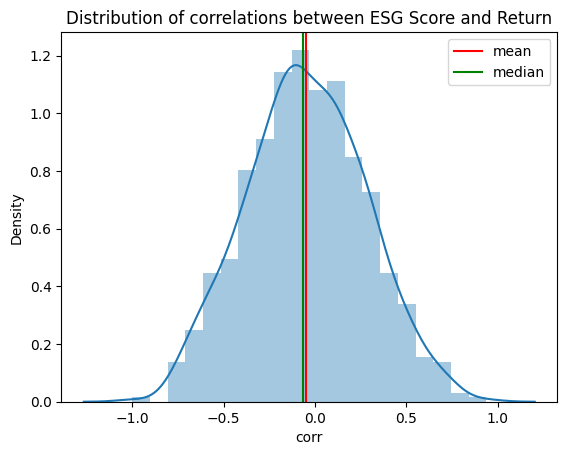

,Company Name,corr
0,3M Co,-0.324451
1,3i Group PLC,0.054119
2,A G Barr PLC,-0.349899
3,A2A SpA,-0.080792
4,AES Corp,-0.133613
...,...,...
663,YIT Oyj,-0.124979
664,Yamana Gold Inc,-0.709616
665,Yara International ASA,0.352517
666,Yum! Brands Inc,-0.576282


In [37]:
group_corr(df_individual_scores_10Y_clean, "ESG Score", "Return", column_grop="Company Name")

In [38]:
#lagged correlation
for col_ in df_pillar_scores_10Y_EBITDA_volatility.columns:
    if col_ != "Period" and col_ != "Cluster" and col_ != "Company Name" and col_ != "Return" and col_ != "Volatility" and col_ != "EBITDA Margin, Percent" and col_ != "RIC":
        print("Correlation of " + col_ + " with:")
        print("Return")
        print(lagged_corr(df_pillar_scores_10Y_EBITDA_volatility, col_, "Return", column_grop="Company Name", p=1, time_column="Period")["lagged_correlation"].mean())
        print("Volatility")
        print(lagged_corr(df_pillar_scores_10Y_EBITDA_volatility, col_, "Volatility", column_grop="Company Name", p=1, time_column="Period")["lagged_correlation"].mean())
        print("EBITDA Margin, Percent")
        print(lagged_corr(df_pillar_scores_10Y_EBITDA_volatility, col_, "EBITDA Margin, Percent", column_grop="Company Name", p=1, time_column="Period")["lagged_correlation"].mean())


Correlation of Resource Use Score with:
Return
-0.03266898808948794
Volatility
0.1101772133479059
EBITDA Margin, Percent
0.018781707303137052
Correlation of Shareholders Score with:
Return
0.001268458753067594
Volatility
0.03038165589920559
EBITDA Margin, Percent
0.016331636600470757
Correlation of ESG Combined Score with:
Return
-0.04741114117593908
Volatility
0.13265419369473155
EBITDA Margin, Percent
0.05982261941372605
Correlation of Environmental Innovation Score with:
Return
-0.032991342242789046
Volatility
0.07006170708016184
EBITDA Margin, Percent
0.019114879852657665
Correlation of Human Rights Score with:
Return
-0.04343783094316047
Volatility
0.17112196554209844
EBITDA Margin, Percent
0.051076637249163115
Correlation of Social Pillar Score with:
Return
-0.05878386404983122
Volatility
0.16309729845636917
EBITDA Margin, Percent
0.07952476374978486
Correlation of Community Score with:
Return
-0.02610112969890054
Volatility
0.0651992126904248
EBITDA Margin, Percent
0.03016296085

Analyse Cluster high level categories

Cluster 0
Finance       52
Consumer       6
Tech           5
Energy         4
Healthcare     1
Name: Category, dtype: int64



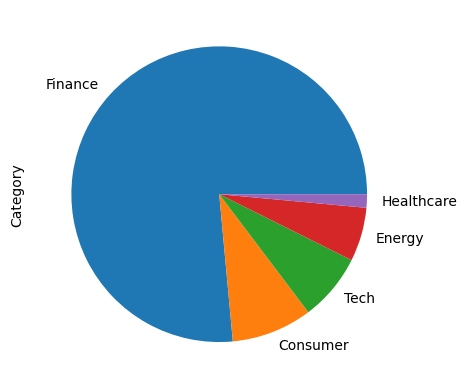

Cluster 1
Finance       75
Consumer      55
Energy        34
Tech          34
Healthcare    11
Name: Category, dtype: int64



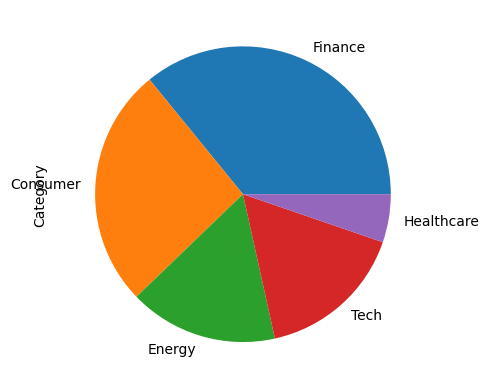

Cluster 2
Consumer      47
Tech          37
Energy        27
Finance       17
Healthcare    17
Name: Category, dtype: int64



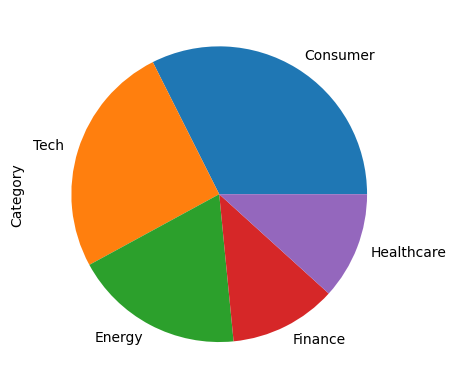

Cluster 3
Energy        73
Consumer      21
Tech           8
Finance        7
Healthcare     7
Name: Category, dtype: int64



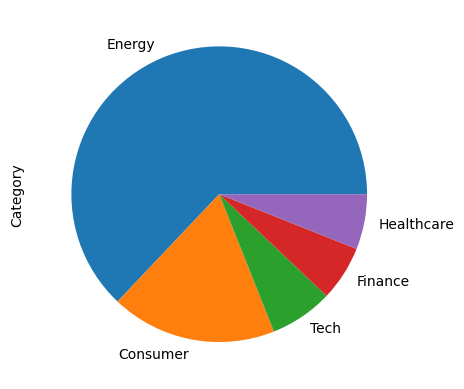

Cluster 4
Energy        72
Finance       26
Consumer      15
Tech           9
Healthcare     8
Name: Category, dtype: int64



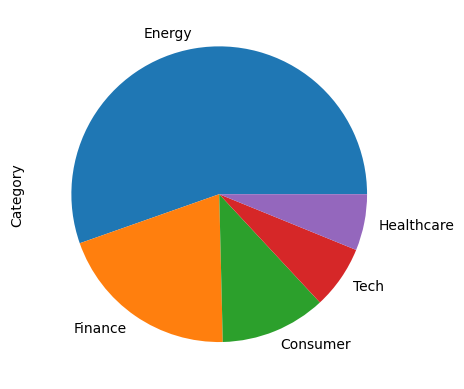

Composition of the data
Cluster 0 contains 68 companies

Cluster 1 contains 209 companies

Cluster 2 contains 145 companies

Cluster 3 contains 116 companies

Cluster 4 contains 130 companies



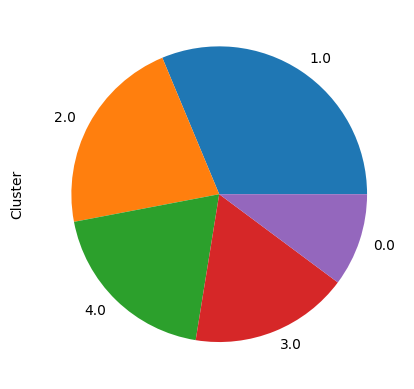

In [39]:
df_individual_scores_10Y_clean_Cluster = df_individual_scores_10Y_clean.copy()

#make dictionary with categories as values and whats in list as keys
categories_dict = {}
for category in healthcare_categories:
    categories_dict[category] = "Healthcare"
for category in consumer_categories:
    categories_dict[category] = "Consumer"
for category in tech_categories:
    categories_dict[category] = "Tech"
for category in finance_categories:
    categories_dict[category] = "Finance"
for category in energy_categories:
    categories_dict[category] = "Energy"
    
#add the high level category to the dataframe
df_individual_scores_10Y_clean_Cluster["Category"] = df_individual_scores_10Y_clean_Cluster["GICS Industry Name"].apply(lambda x: categories_dict[x] if x in categories_dict.keys() else "Other")

#make mean of each company
#get numeric columns
numeric_columns = df_individual_scores_10Y_clean_Cluster.select_dtypes(include=np.number).columns.tolist()
other_columns = [x for x in df_individual_scores_10Y_clean_Cluster.columns.tolist() if x not in numeric_columns]
df_individual_scores_10Y_clean_Cluster = df_individual_scores_10Y_clean_Cluster.groupby('Company Name').agg({col: 'mean' for col in numeric_columns} | {col: lambda x: x.mode()[0] for col in other_columns})



#print the composition of each cluster as an overview, 
for cluster in range(0, 5):
    print("Cluster " + str(cluster))
    print(df_individual_scores_10Y_clean_Cluster[df_individual_scores_10Y_clean_Cluster["Cluster"] == cluster]["Category"].value_counts())
    print("")
    
    #also return as pie chart
    df_individual_scores_10Y_clean_Cluster[df_individual_scores_10Y_clean_Cluster["Cluster"] == cluster]["Category"].value_counts().plot.pie()
    plt.show()
    
#get a pie chart of the composition of the data (wich cluster has how many companies)
print("Composition of the data")
for cluster in range(0, 5):
    print("Cluster " + str(cluster) + " contains " + str(df_individual_scores_10Y_clean_Cluster[df_individual_scores_10Y_clean_Cluster["Cluster"] == cluster]["Category"].value_counts().sum()) + " companies") 
    print("")
    #also return as pie chart
df_individual_scores_10Y_clean_Cluster["Cluster"].value_counts().plot.pie()
plt.show()

##### Lets perform the Granger tests

##### Granger tests simple

ESG and Returns

In [40]:
residuals_1, residuals_2, residuals_3, y,coeffs_1, coeffs_2, coeffs_3 = check_granger_simple(df_individual_scores_10Y_clean_transformed, p=5, column_A= "Return", column_B= "ESG Score")

R-squared (Model 1): 0.037406144474124714
R-squared (Model 2): 0.06128144219266196
R-squared (Model 3): 0.08959002351454814
F-statistic (Model 1 vs Model 2): 1.0011806766331985
F-statistic (Model 1 vs Model 3): 1.0332528095461007
Critical value (Model 1 vs Model 2): 1.0340732528488097
Critical value (Model 1 vs Model 3): 1.0340732528488097
Test whether random noise improves Model 1:
Accept the null hypothesis that the variances are equal
Test whether column_B improves Model 1:
Accept the null hypothesis that the variances are equal


In [41]:
#perform the industy beta analysis for every cluster
for int_cluster in range(5):
    print("============= \n\n")
    print(f"Cluster {int_cluster}")
    #Zeilenumbruch
    check_granger_industry_beta(df_individual_scores_10Y_clean_transformed, p=2, column_A= "Return", column_B= "ESG Score",column_industry="Cluster", industry_name=int_cluster)



Cluster 0
R-squared (Model 1): 0.07824579387542596
R-squared (Model 2): -0.0054609370995406525
R-squared (Model 3): 0.08820480852040968
F-statistic (Model 1 vs Model 2): 0.9899866571477757
F-statistic (Model 1 vs Model 3): 1.0130588461608316
Critical value (Model 1 vs Model 2): 1.0767915394163572
Critical value (Model 1 vs Model 3): 1.0767915394163572
Accept the null hypothesis that the variances are equal
Accept the null hypothesis that the variances are equal


Cluster 1
R-squared (Model 1): 0.04335638148487986
R-squared (Model 2): 0.031997310890156894
R-squared (Model 3): -0.22083942847072935
F-statistic (Model 1 vs Model 2): 0.9977842638737788
F-statistic (Model 1 vs Model 3): 0.994453666575822
Critical value (Model 1 vs Model 2): 1.0768722570648273
Critical value (Model 1 vs Model 3): 1.0768722570648273
Accept the null hypothesis that the variances are equal
Accept the null hypothesis that the variances are equal


Cluster 2
R-squared (Model 1): 0.04684232800440624
R-squared (Mo

##### Granger Test on clusters with Gradient Descent optimization

ESG and Returns

In [42]:
for int_cluster in range(5):
    print("============= \n\n")
    print(f"Cluster {int_cluster}")
    #Zeilenumbruch
    residuals_1, residuals_2, residuals_3, y,coeffs_1_industry, coeffs_2_industry, coeffs_3_industry = granger_industry_gradient_descent(df_individual_scores_10Y_clean,2,"Return","ESG Score","Cluster",[int_cluster],0.0001)



Cluster 0


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Model 1: Return
Model 2: Return, random
Model 3: Return, ESG Score
R-squared (Model 1): 0.05754778230926327
R-squared (Model 2): 0.18180229712408535
R-squared (Model 3): 0.39950430859608554
F-statistic (Model 1 vs Model 2): 7.490398361251306
F-statistic (Model 1 vs Model 3): 41566.26748038211
Critical value (Model 1 vs Model 2): 1.0767915394163572
Critical value (Model 1 vs Model 3): 1.0767915394163572
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Cluster 1


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Model 1: Return
Model 2: Return, random
Model 3: Return, ESG Score
R-squared (Model 1): 0.01827066433151614
R-squared (Model 2): -0.19001155301142952
R-squared (Model 3): 0.08687808522223966
F-statistic (Model 1 vs Model 2): 4.752795362538444
F-statistic (Model 1 vs Model 3): 4780.302676406017
Critical value (Model 1 vs Model 2): 1.0768722570648273
Critical value (Model 1 vs Model 3): 1.0768722570648273
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Cluster 2


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Model 1: Return
Model 2: Return, random
Model 3: Return, ESG Score
R-squared (Model 1): 0.02221411745947044
R-squared (Model 2): -0.18722331487810656
R-squared (Model 3): -0.06776069599323142
F-statistic (Model 1 vs Model 2): 5.6394160630286425
F-statistic (Model 1 vs Model 3): 4412.536399866278
Critical value (Model 1 vs Model 2): 1.0919346062616258
Critical value (Model 1 vs Model 3): 1.0919346062616258
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Cluster 3


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Model 1: Return
Model 2: Return, random
Model 3: Return, ESG Score
R-squared (Model 1): 0.005923110878297888
R-squared (Model 2): -0.1859885728773551
R-squared (Model 3): -0.05435923519242292
F-statistic (Model 1 vs Model 2): 4.554265238017088
F-statistic (Model 1 vs Model 3): 3714.2723086656424
Critical value (Model 1 vs Model 2): 1.1051284596968713
Critical value (Model 1 vs Model 3): 1.1051284596968713
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Cluster 4


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Model 1: Return
Model 2: Return, random
Model 3: Return, ESG Score
R-squared (Model 1): -0.00951408828615219
R-squared (Model 2): -0.19964963792527773
R-squared (Model 3): 0.016870139501833248
F-statistic (Model 1 vs Model 2): 4.729165064814806
F-statistic (Model 1 vs Model 3): 4113.652689263746
Critical value (Model 1 vs Model 2): 1.0992296387920388
Critical value (Model 1 vs Model 3): 1.0992296387920388
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


ESG and EBITDA

In [45]:
for int_cluster in range(0,5):
    print("============= \n\n")
    print(f"Cluster {int_cluster}")
    #Zeilenumbruch
    residuals_1, residuals_2, residuals_3, y,coeffs_1_industry, coeffs_2_industry, coeffs_3_industry = granger_industry_gradient_descent(df_pillar_scores_10Y_EBITDA_volatility_clean,2,"EBITDA Margin, Percent","ESG Score","Cluster",[int_cluster],0.0000025)



Cluster 0


100%|██████████| 595/595 [00:04<00:00, 126.70it/s]


Model 1: EBITDA Margin, Percent
Model 2: EBITDA Margin, Percent, random
Model 3: EBITDA Margin, Percent, ESG Score
R-squared (Model 1): -0.27243622560184244
R-squared (Model 2): 0.22017558899648287
R-squared (Model 3): 0.4394070791646418
F-statistic (Model 1 vs Model 2): 1.0905994018904677
F-statistic (Model 1 vs Model 3): 4268.3912953254385
Critical value (Model 1 vs Model 2): 1.0767915394163572
Critical value (Model 1 vs Model 3): 1.0767915394163572
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Cluster 1


100%|██████████| 454/454 [00:02<00:00, 152.16it/s]


Model 1: EBITDA Margin, Percent
Model 2: EBITDA Margin, Percent, random
Model 3: EBITDA Margin, Percent, ESG Score
R-squared (Model 1): -1.2476832568894425
R-squared (Model 2): -0.3605049263875192
R-squared (Model 3): -0.4851724955968108
F-statistic (Model 1 vs Model 2): 1.764894756905429
F-statistic (Model 1 vs Model 3): 1013.5959860382235
Critical value (Model 1 vs Model 2): 1.0768722570648273
Critical value (Model 1 vs Model 3): 1.0768722570648273
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Cluster 2


100%|██████████| 520/520 [00:03<00:00, 161.33it/s]


Model 1: EBITDA Margin, Percent
Model 2: EBITDA Margin, Percent, random
Model 3: EBITDA Margin, Percent, ESG Score
R-squared (Model 1): -3.578143455956245
R-squared (Model 2): -0.5573767999257546
R-squared (Model 3): 0.07680605983506161
F-statistic (Model 1 vs Model 2): 4.865655870270756
F-statistic (Model 1 vs Model 3): 2180.49550011697
Critical value (Model 1 vs Model 2): 1.0919346062616258
Critical value (Model 1 vs Model 3): 1.0919346062616258
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Cluster 3


100%|██████████| 548/548 [00:04<00:00, 120.10it/s]


Model 1: EBITDA Margin, Percent
Model 2: EBITDA Margin, Percent, random
Model 3: EBITDA Margin, Percent, ESG Score
R-squared (Model 1): -1.7342429588868131
R-squared (Model 2): -0.43247608075743293
R-squared (Model 3): 0.17490331076040433
F-statistic (Model 1 vs Model 2): 2.682672769163089
F-statistic (Model 1 vs Model 3): 1116.166530766176
Critical value (Model 1 vs Model 2): 1.1051284596968713
Critical value (Model 1 vs Model 3): 1.1051284596968713
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Cluster 4


100%|██████████| 535/535 [00:03<00:00, 137.11it/s]

Model 1: EBITDA Margin, Percent
Model 2: EBITDA Margin, Percent, random
Model 3: EBITDA Margin, Percent, ESG Score
R-squared (Model 1): -5.562569256767347e-05
R-squared (Model 2): -0.20921114909868732
R-squared (Model 3): 0.21623802935053088
F-statistic (Model 1 vs Model 2): 0.5011378452122814
F-statistic (Model 1 vs Model 3): 1.024291115934018
Critical value (Model 1 vs Model 2): 1.0992296387920388
Critical value (Model 1 vs Model 3): 1.0992296387920388
Accept the null hypothesis that the variances are equal
Accept the null hypothesis that the variances are equal


ESG and Volatility

In [48]:
for int_cluster in range(1,5):
    print("============= \n\n")
    print(f"Cluster {int_cluster}")
    #Zeilenumbruch
    residuals_1, residuals_2, residuals_3, y,coeffs_1_industry, coeffs_2_industry, coeffs_3_industry = granger_industry_gradient_descent(df_pillar_scores_10Y_EBITDA_volatility,2,"Volatility","ESG Score","Cluster",[int_cluster],0.0000025)



Cluster 1


100%|██████████| 452/452 [00:03<00:00, 113.67it/s]


Model 1: Volatility
Model 2: Volatility, random
Model 3: Volatility, ESG Score
R-squared (Model 1): -0.12212784301514756
R-squared (Model 2): -0.16617728883733673
R-squared (Model 3): 0.1669038308459621
F-statistic (Model 1 vs Model 2): 480.90582034469503
F-statistic (Model 1 vs Model 3): 447553.4976353581
Critical value (Model 1 vs Model 2): 1.0770751561651497
Critical value (Model 1 vs Model 3): 1.0770751561651497
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Cluster 2


100%|██████████| 517/517 [00:03<00:00, 131.99it/s]


Model 1: Volatility
Model 2: Volatility, random
Model 3: Volatility, ESG Score
R-squared (Model 1): -0.14851825770502636
R-squared (Model 2): -0.17611476417348093
R-squared (Model 3): 0.17160990608644322
F-statistic (Model 1 vs Model 2): 1046.4494820572804
F-statistic (Model 1 vs Model 3): 646509.0818557199
Critical value (Model 1 vs Model 2): 1.0920721985524782
Critical value (Model 1 vs Model 3): 1.0920721985524782
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Cluster 3


100%|██████████| 547/547 [00:14<00:00, 36.68it/s]


Model 1: Volatility
Model 2: Volatility, random
Model 3: Volatility, ESG Score
R-squared (Model 1): -0.2513568692401711
R-squared (Model 2): -0.19983084751405022
R-squared (Model 3): 0.16200482192749832
F-statistic (Model 1 vs Model 2): 653.0383510140531
F-statistic (Model 1 vs Model 3): 398576.9051582327
Critical value (Model 1 vs Model 2): 1.1057976869916462
Critical value (Model 1 vs Model 3): 1.1057976869916462
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Cluster 4


KeyboardInterrupt: 

ESG Pillar Scores and EBITDA Margin

In [47]:
for str_pillar in ["Social Pillar Score","Environmental Pillar Score","Governance Pillar Score"]:
    for int_cluster in range(0,5):
        print("============= \n\n")
        print(f"Pillar: {str_pillar}")
        print("============= \n\n")
        print(f"Cluster {int_cluster}")
        #Zeilenumbruch
        residuals_1, residuals_2, residuals_3, y,coeffs_1_industry, coeffs_2_industry, coeffs_3_industry = granger_industry_gradient_descent(df_pillar_scores_10Y_EBITDA_volatility,2,"EBITDA Margin, Percent",str_pillar,"Cluster",[int_cluster],0.0000025)



Pillar: Social Pillar Score


Cluster 0


100%|██████████| 592/592 [00:03<00:00, 151.32it/s]


Model 1: EBITDA Margin, Percent
Model 2: EBITDA Margin, Percent, random
Model 3: EBITDA Margin, Percent, Social Pillar Score
R-squared (Model 1): -0.2710507178222843
R-squared (Model 2): 0.21261657848875187
R-squared (Model 3): -40250.64498772646
F-statistic (Model 1 vs Model 2): 1.0806622504244912
F-statistic (Model 1 vs Model 3): 890234866.435945
Critical value (Model 1 vs Model 2): 1.0770141199003522
Critical value (Model 1 vs Model 3): 1.0770141199003522
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Pillar: Social Pillar Score


Cluster 1


100%|██████████| 452/452 [00:03<00:00, 126.74it/s]


Model 1: EBITDA Margin, Percent
Model 2: EBITDA Margin, Percent, random
Model 3: EBITDA Margin, Percent, Social Pillar Score
R-squared (Model 1): -1.2815355495644805
R-squared (Model 2): -0.37007339177326226
R-squared (Model 3): -7.545292397649139
F-statistic (Model 1 vs Model 2): 1.7321331918287892
F-statistic (Model 1 vs Model 3): 1493.1707678846583
Critical value (Model 1 vs Model 2): 1.0770751561651497
Critical value (Model 1 vs Model 3): 1.0770751561651497
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Pillar: Social Pillar Score


Cluster 2


100%|██████████| 517/517 [00:02<00:00, 182.24it/s]


Model 1: EBITDA Margin, Percent
Model 2: EBITDA Margin, Percent, random
Model 3: EBITDA Margin, Percent, Social Pillar Score
R-squared (Model 1): -3.6700652631323187
R-squared (Model 2): -0.7390711677273615
R-squared (Model 3): -19.123472238433894
F-statistic (Model 1 vs Model 2): 4.869459315211302
F-statistic (Model 1 vs Model 3): 3640.7715595938653
Critical value (Model 1 vs Model 2): 1.0920721985524782
Critical value (Model 1 vs Model 3): 1.0920721985524782
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Pillar: Social Pillar Score


Cluster 3


100%|██████████| 547/547 [00:05<00:00, 95.14it/s] 


Model 1: EBITDA Margin, Percent
Model 2: EBITDA Margin, Percent, random
Model 3: EBITDA Margin, Percent, Social Pillar Score
R-squared (Model 1): -1.774206337548562
R-squared (Model 2): -0.4409084349546225
R-squared (Model 3): -9.864434883020522
F-statistic (Model 1 vs Model 2): 2.755743045492186
F-statistic (Model 1 vs Model 3): 2335.0657401091576
Critical value (Model 1 vs Model 2): 1.1057976869916462
Critical value (Model 1 vs Model 3): 1.1057976869916462
Reject the null hypothesis that the variances are equal
Reject the null hypothesis that the variances are equal


Pillar: Social Pillar Score


Cluster 4


 43%|████▎     | 227/532 [00:06<00:08, 34.33it/s]


KeyboardInterrupt: 

ESG Pillar Scores and Volatility

In [ ]:
for str_pillar in ["Social Pillar Score","Environmental Pillar Score","Governance Pillar Score"]:
    for int_cluster in range(0,5):
        #iterate over all clusters and pillars
        print("============= \n\n")
        print(f"Pillar: {str_pillar}")
        print("============= \n\n")
        print(f"Cluster {int_cluster}")
        #Zeilenumbruch
        residuals_1, residuals_2, residuals_3, y,coeffs_1_industry, coeffs_2_industry, coeffs_3_industry = granger_industry_gradient_descent(df_pillar_scores_10Y_EBITDA_volatility,2,"EBITDA Margin, Percent",str_pillar,"Cluster",[int_cluster],0.000025)